Get data.
try multiple clustering algorithms and plot the profiles

In [1]:
import pandas, seaborn, numpy, pyensembl, scipy, os

import sklearn, sklearn.cluster
import statsmodels, statsmodels.stats, statsmodels.stats.multitest

%matplotlib inline
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(8, 4), 'axes.labelsize':20})

# 0. user-defined variables

In [2]:
#! drangajokull
home_dir = '/home/adrian/'

#! necio5
home_dir = '/Users/adrian/'

In [3]:
dorothea_regulons_dir = home_dir + 'databases/dorothea/regulons/'
down_file = home_dir + 'gd15/hi/research/osteo/results/up_and_down_DEGs/down.csv'
overall_file = home_dir + 'gd15/hi/research/osteo/results/up_and_down_DEGs/all_zscore.csv'
regulons_results_file = home_dir + 'gd15/hi/research/osteo/results/regulons/regulons_down.csv'
scratch_dir = home_dir + 'scratch/'

days = [3, 6, 9, 16, 28]

# 1. read data

## 1.1. read expression data

In [4]:
expression = pandas.read_csv(down_file, index_col=0)

print(expression.shape)
expression.head()

(520, 5)


,Day_3,Day_6,Day_9,Day_16,Day_28
ENSG00000107562,-0.464413,0.742508,1.551882,-0.640892,-1.189085
ENSG00000081041,-0.846169,-0.256214,1.032884,1.289558,-1.220059
ENSG00000250657,1.491155,-0.237134,-1.544533,0.527646,-0.237134
ENSG00000212724,1.825742,0.000000,-0.912871,0.000000,-0.912871
ENSG00000262862,1.825742,0.000000,-0.912871,0.000000,-0.912871


In [5]:
overall_expression = pandas.read_csv(overall_file, index_col=0)

print(overall_expression.shape)
overall_expression.head()

(61881, 5)


,Day_3,Day_6,Day_9,Day_16,Day_28
ENSG00000000003,-1.652464,0.509438,1.011249,0.765363,-0.633587
ENSG00000000005,NaN,NaN,NaN,NaN,NaN
ENSG00000000419,0.388132,-0.813199,-1.316938,1.555271,0.186734
ENSG00000000457,0.500000,0.500000,0.500000,0.500000,-2.000000
ENSG00000000460,1.648206,-0.777687,-0.777687,0.684855,-0.777687


## 1.2. read TF-gene interactions

In [6]:
regulons = {}
regulon_files = os.listdir(dorothea_regulons_dir)
for file in regulon_files:
    TF_name = file.split('.txt')[0]
    df = pandas.read_csv(dorothea_regulons_dir+file, sep='\t', header=None, names=['target'])
    targets = df['target'].to_list()
    regulons[TF_name] = targets

In [7]:
annotation = pyensembl.EnsemblRelease(86) 
annotation

EnsemblRelease(release=86, species='homo_sapiens')

In [8]:
# 16 missing for annotation 75
# 11 missing for annotation 86
# 11 missing for annotation 100
# 12 missing for annotation 102
down_genes = expression.index.to_list()
rosetta_down_genes = {}

missing = 0
for ensembl in down_genes:
    try:
        gene_name = annotation.gene_by_id(ensembl).gene_name
        rosetta_down_genes[ensembl] = gene_name
    except:
        missing = missing + 1
        print('Missing #{}. {} not found'.format(missing, ensembl))

Missing #1. ENSG00000262862 not found
Missing #2. ENSG00000277909 not found
Missing #3. ENSG00000281166 not found
Missing #4. ENSG00000280610 not found
Missing #5. ENSG00000280682 not found
Missing #6. ENSG00000280641 not found
Missing #7. ENSG00000233450 not found
Missing #8. ENSG00000262634 not found
Missing #9. ENSG00000275125 not found
Missing #10. ENSG00000281165 not found
Missing #11. ENSG00000276657 not found


In [9]:
# define M, the number of target genes in Dorothea regulons
all_targets = []
for TF in regulons:
    for element in regulons[TF]:
        all_targets.append(element)
M = len(list(set(all_targets)))
print('found {} targets'.format(M))

found 20295 targets


# 2. format data

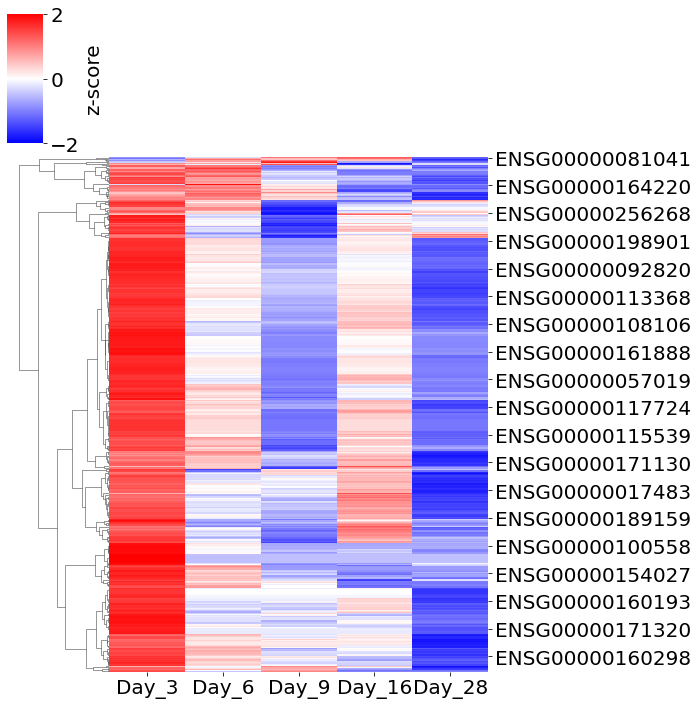

In [10]:
linkage_method = 'complete'
distance_metric = 'cosine'

seaborn.clustermap(expression, cmap='bwr', vmin=-2, vmax=2, col_cluster=False, method=linkage_method, metric=distance_metric,  cbar_kws={'label':'z-score'})
matplotlib.pyplot.show()

In [11]:
x = expression.to_numpy()
x

array([[-0.46441292,  0.74250813,  1.55188165, -0.64089176, -1.18908511],
       [-0.84616885, -0.2562144 ,  1.03288391,  1.28955806, -1.22005872],
       [ 1.49115456, -0.23713368, -1.54453325,  0.52764605, -0.23713368],
       ...,
       [ 1.43748922, -0.46114954,  0.94031261, -0.95832615, -0.95832615],
       [ 1.04313082,  1.04313082,  0.24940485, -1.03767107, -1.29799543],
       [ 1.7456559 ,  0.45030328, -0.57787594, -1.0402073 , -0.57787594]])

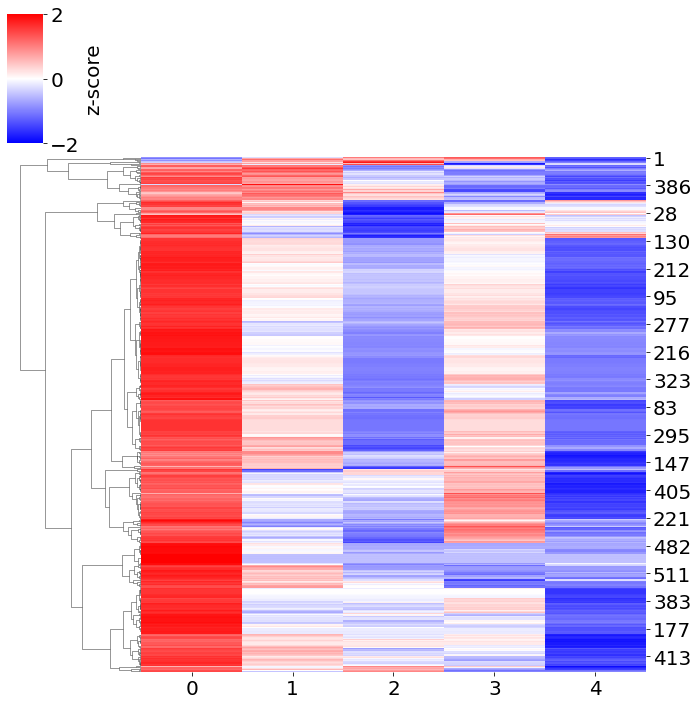

In [12]:
seaborn.clustermap(x, cmap='bwr', vmin=-2, vmax=2, col_cluster=False, method=linkage_method, metric=distance_metric,  cbar_kws={'label':'z-score'})
matplotlib.pyplot.show()

# 3. define partition range

In [13]:
number_elements = expression.shape[0]
fine = int(number_elements/5)
coarse = int(number_elements/20)
print(coarse, fine)
k_range = range(coarse, fine+1)
k_range = range(3, 45)

26 104


# 4. learning

In [14]:
###
### informative cell about hypergeometric test
###

# M is the population size
# n is the number of successes in the population 
# N is the sample size (previously n)
# x is still the number of drawn “successes”

# M is the total number of targets in Dorothea
# n is the number of targets of a particular TF in Dorothea
# N is the size of DETs
# x is the number of DETs that are targets of a particular TF

M = 20000
n = 200

N = 1000
xint = 20 # 10 would be the same ratio

print('p-value <= ' + str(xint) + ': ' + str(scipy.stats.hypergeom.cdf(xint, M, n, N)))
print('p-value >= ' + str(xint)  + ': ' + str(scipy.stats.hypergeom.sf(xint-1, M, n, N)))

p-value <= 20: 0.9989104333089479
p-value >= 20: 0.0025301883214874205


In [15]:
log = open(scratch_dir + 'log.txt', 'w')

In [16]:
def tf_enrichment(k, labels):
    
    domain = []; controllers = [] 
    regulons_membership = {}; regulons_activity = {}; regulons_quant = {}
    cluster_id_map = {}
    
    figures_dir = scratch_dir + str(k) + '/'
    if os.path.exists(figures_dir) == False:
        os.mkdir(figures_dir)
    
    for ki in range(k): ### iteration over clusters in a given partition
        
        indices = numpy.where(labels == ki)[0]
        log.write('\nCluster c{} with {} gene indices: {}\n'.format(ki, len(indices), indices))
        cluster = expression.iloc[indices, :]
        cluster_average = cluster.mean().values

        ###
        ### plotting
        ###
#         for gene in cluster.index:
#             matplotlib.pyplot.plot(days, cluster.loc[gene, :], 'o-')
#         matplotlib.pyplot.xlabel('Time (day)')
#         matplotlib.pyplot.ylabel('zscore')
#         matplotlib.pyplot.grid(alpha=0.5, ls=':')
#         matplotlib.pyplot.ylim([-2, 2])
#         matplotlib.pyplot.xlim(([0, 29]))
#         matplotlib.pyplot.title('k={} | c{}'.format(k, ki))
#         matplotlib.pyplot.tight_layout()
#         matplotlib.pyplot.savefig(figures_dir+'c{}.pdf'.format(ki))
#         matplotlib.pyplot.clf()
        
        ###
        ### convert cluster ENSEMBL ids into gene names
        ###
        cluster_ensembl_ids = expression.index[indices]
        cluster_gene_names = []
        for ensembl in cluster_ensembl_ids:
            try:
                gene_name = rosetta_down_genes[ensembl]
                cluster_gene_names.append(gene_name)
                cluster_id_map[gene_name] = ensembl
            except:
                log.write('ENSEMBL ID {} lost.\n'.format(ensembl))
        log.write('{}/{} genes recovered.\n'.format(len(cluster_gene_names), len(cluster_ensembl_ids)))

        ###
        ### enrichment
        ###

        # define N, the size of the regulon
        N = len(cluster_gene_names)

        # get all TFs regulating each target gene
        putative_TFs = []
        for gene_name in cluster_gene_names:
            for TF in regulons:
                if gene_name in regulons[TF]:
                    putative_TFs.append(TF)
        putative_regulators = list(set(putative_TFs))
        putative_regulators.sort()
        log.write('all possible regulators of this cluster:{}\n'.format(len(putative_regulators)))

        # hypergeometric test for putative regulators
        p_values_uncorrected = []
        hits_tracker = [] # store tuples of information
        for putative_regulator in putative_regulators:

            # define n, the number of targets of that particular TF in Dorothea
            global_TF_targets = regulons[putative_regulator]
            n = len(global_TF_targets)

            # define x, the number of DETs that are targets of that particular TF
            intersect = list(set(cluster_gene_names) & set(global_TF_targets))
            x = len(intersect)

            # make sure that the regulon has at least two target genes for a given TF, otherwise, don't waste hypothesis correction
            if x >= 2:
                pvalue = scipy.stats.hypergeom.sf(x-1, M, n, N)
                p_values_uncorrected.append(pvalue)
                
                # compute activity
                intersect_ensembl = [cluster_id_map[element] for element in intersect]
                activity = expression.loc[intersect_ensembl, :].mean().values
                
                # prepare information in a tuple
                tracking_tuple = (putative_regulator, n, M, x, N, round(x/N, 3), intersect, activity)
                hits_tracker.append(tracking_tuple)

        # multiple correction for all putative regulators of this cluster: Benjamini–Hochberg correction
        alternative, corrected_p_values = statsmodels.stats.multitest.fdrcorrection(p_values_uncorrected, alpha=0.1)
        for i in range(len(alternative)):
            if alternative[i] == True:
                
                # compute correlation: first TF, then just get the activity of those target genes, not the cluster
                
                # TF
                recovered_ids = annotation.genes_by_name(hits_tracker[i][0])
                if len(recovered_ids) == 1:
                    tf_id = recovered_ids[0].gene_id
                else:
                    tf_id = [element.gene_id for element in recovered_ids]
                    log.write('WARNING: two IDs found for a given TF. First selected.')
                    log.write('{}\n'.format(tf_id))
                    #print(overall_expression.loc[tf_id, :].values)
                    #print(overall_expression.loc[tf_id, :].mean().values)
                    #print('----')
                try:
                    tf_trend = overall_expression.loc[tf_id, :].values
                    #print(overall_expression.loc[tf_id, :].values)
                    #print(overall_expression.loc[tf_id, :].mean().values)
                    #print('---')
                except:
                    log.write('\t TF {} not found in overall expression\n'.format(tf_id))
                    tf_trend = [numpy.NAN]
                
                if numpy.isnan(tf_trend).any() == True:
                    pcc = 0
                else:
                    pcc, pvalue = scipy.stats.pearsonr(tf_trend, hits_tracker[i][7])
                
                if pcc > 0.8:
                    log.write('\t HIT: {} {}\n'.format(round(pcc, 3), hits_tracker[i][:-1]))
                    
                    controllers.append(hits_tracker[i][0])
                    for element in hits_tracker[i][6]:
                        domain.append(element)
                    
                    # merging if necessary
                    if hits_tracker[i][0] not in regulons_membership:
                        regulons_membership[hits_tracker[i][0]] = hits_tracker[i][6]
                        regulons_quant[hits_tracker[i][0]] = [(pcc, corrected_p_values[i])]
                    else:
                        for element in hits_tracker[i][6]:
                            regulons_membership[hits_tracker[i][0]].append(element)
                        regulons_quant[hits_tracker[i][0]].append((pcc, corrected_p_values[i]))
                        log.write('\t\tmerged two regulons that shared TF {}\n'.format(hits_tracker[i][0]))
                        
    # compute the domain
    unique_domain = list(set(domain))
    domain_size = len(unique_domain)
    
    unique_controllers = list(set(controllers))
    controllers_size = len(unique_controllers)
    
    # compute regulon activity
    for TF in regulons_membership:
        targets = regulons_membership[TF]
        targets_ensembl = [cluster_id_map[gene_name] for gene_name in targets]
        activity = expression.loc[targets_ensembl, :].mean().values
        regulons_activity[TF] = activity
                
    return domain_size, controllers_size, regulons_membership, regulons_activity, regulons_quant

In [17]:
###
### iteration over k
###

p_ss = []; p_khi = []; p_dbi = []; p_dom = []; p_control = []; p_quant = []
p_rm = []; p_ra = []

for k in k_range:
    
    print(k)
    
    log.write('\nWORKING WITH k={}\n'.format(k))

    partition = sklearn.cluster.AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='complete').fit(x)
    labels = partition.labels_

    ss = sklearn.metrics.silhouette_score(x, labels, metric='cosine')
    khi = sklearn.metrics.calinski_harabasz_score(x, labels)
    dbi = sklearn.metrics.davies_bouldin_score(x, labels)

    p_ss.append(ss)
    p_khi.append(khi)
    p_dbi.append(dbi)
    
    domain_size, controllers_size, regulons_membership, regulons_activity, regulons_quant = tf_enrichment(k, labels)
    
    p_dom.append(domain_size)
    p_control.append(controllers_size)
    
    p_rm.append(regulons_membership)
    p_ra.append(regulons_activity)
    p_quant.append(regulons_quant)

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


In [18]:
log.close()

In [19]:
# need to do with K means and all other methods present in sklearn that are inductive (?)

## 4.1. plot learned results

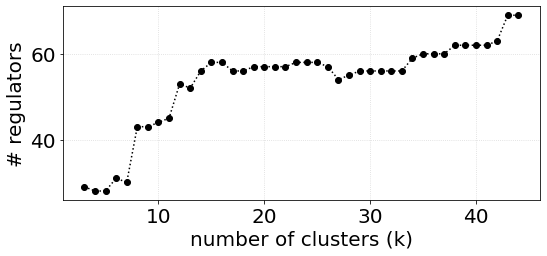

In [20]:
matplotlib.pyplot.plot(k_range, p_control, 'ok')
matplotlib.pyplot.plot(k_range, p_control, ':', color='black')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('# regulators')
matplotlib.pyplot.tight_layout()

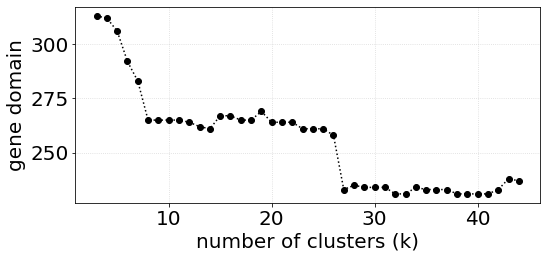

In [21]:
matplotlib.pyplot.plot(k_range, p_dom, 'ok')
matplotlib.pyplot.plot(k_range, p_dom, ':', color='black')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('gene domain')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.tight_layout()

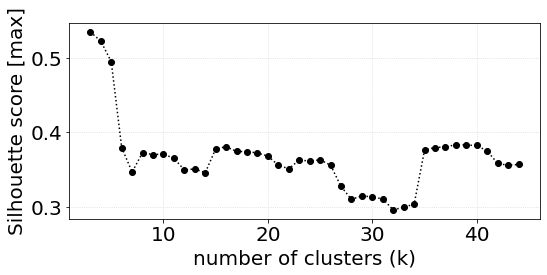

In [22]:
matplotlib.pyplot.plot(k_range, p_ss, 'ok')
matplotlib.pyplot.plot(k_range, p_ss, ':', color='black')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Silhouette score [max]')
matplotlib.pyplot.tight_layout()

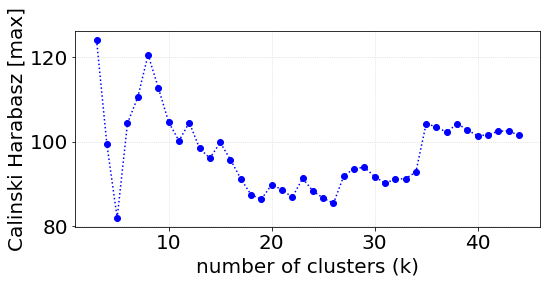

In [23]:
matplotlib.pyplot.plot(k_range, p_khi, 'ob')
matplotlib.pyplot.plot(k_range, p_khi, ':', color='blue')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Calinski Harabasz [max]')
matplotlib.pyplot.tight_layout()

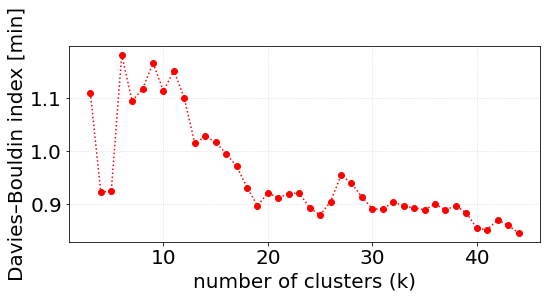

In [24]:
matplotlib.pyplot.plot(k_range, p_dbi, 'or')
matplotlib.pyplot.plot(k_range, p_dbi, ':', color='red')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Davies–Bouldin index [min]')
matplotlib.pyplot.tight_layout()

# 5. store results

In [25]:
for i in range(len(k_range)):
    print(i, k_range[i])
    
    if k_range[i] == 41:
        print('\t storing')
        regulons_membership = p_rm[i]
        regulons_activity = p_ra[i]
        quant = p_quant[i]

0 3
1 4
2 5
3 6
4 7
5 8
6 9
7 10
8 11
9 12
10 13
11 14
12 15
13 16
14 17
15 18
16 19
17 20
18 21
19 22
20 23
21 24
22 25
23 26
24 27
25 28
26 29
27 30
28 31
29 32
30 33
31 34
32 35
33 36
34 37
35 38
36 39
37 40
38 41
	 storing
39 42
40 43
41 44


In [26]:
regulons_activity

{'E2F4': array([ 1.67024811,  0.05486201, -0.70833258,  0.18571932, -1.20249686]),
 'FOXM1': array([ 1.61050155,  0.19049865, -0.83421832,  0.25525003, -1.22203192]),
 'MYBL2': array([ 1.45816896,  0.27935262, -0.80956535,  0.44526192, -1.37321815]),
 'YBX1': array([ 1.51468894,  0.03049127, -0.87534191,  0.56848598, -1.23832428]),
 'ZNF726': array([ 1.66247772,  0.16015831, -0.71971676,  0.11310948, -1.21602876]),
 'ZNF93': array([ 1.67499647,  0.13626181, -0.63959935,  0.06114119, -1.23280011]),
 'PRDM16': array([ 1.2229704 ,  0.70038159,  0.02536003, -0.36398649, -1.58472553]),
 'ZNF714': array([ 1.6866031 ,  0.08978217, -0.71069175,  0.11944345, -1.18513698]),
 'ARID3B': array([ 1.81768873, -0.15940762, -0.25096237, -0.20051238, -1.20680636]),
 'ARNTL2': array([ 1.8125381 , -0.0565014 , -0.20791228, -0.32832536, -1.21979906]),
 'E2F1': array([ 1.72150067,  0.06149779, -0.66932618,  0.06509395, -1.17876623]),
 'E2F7': array([ 1.80271426,  0.0114736 , -0.29134816, -0.29134816, -1.231

In [27]:
with open(regulons_results_file, 'w') as f:
    
    f.write('TF\tRegulon size\tTarget genes\tTF-targets PCC\tEnrichment corrected P value\tActivity on Day 3\tActivity on Day 6\tActivity on Day 9\tActivity on Day 16\tActivity on Day 28\n')
    
    for tf in regulons_membership:
        
        f.write(tf)
        f.write('\t{}'.format(len(regulons_membership[tf])))
        
        gene_string = ', '.join(regulons_membership[tf])
        f.write('\t{}'.format(gene_string))
        
        # pcc and correcte P value
        mean_pcc = numpy.mean([element[0] for element in quant[tf]])
        mean_pvalue = numpy.mean([element[1] for element in quant[tf]])
        print(tf, mean_pcc, mean_pvalue)
        f.write('\t{}\t{:.2e}'.format(round(mean_pcc, 3), round(mean_pvalue, 4)))
        
        # activity
        for element in regulons_activity[tf]:
            f.write('\t{}'.format(round(element, 3)))
        
        f.write('\n')

E2F4 0.8438537876505577 0.0001317542091671488
FOXM1 0.978687691218305 0.01783808628333887
MYBL2 0.8936889358101685 0.04645697684474536
YBX1 0.865870057498077 0.04616861735478986
ZNF726 0.8988328248826034 0.0032351220077600296
ZNF93 0.9487242938380328 0.01018008337054045
PRDM16 0.8873393037549001 0.05556063331487538
ZNF714 0.9572994715290024 0.026075226438044743
ARID3B 0.9191063051556001 0.02970611672105237
ARNTL2 0.8408377725760491 0.0277802591033883
E2F1 0.9419432844920771 0.021456738087005607
E2F7 0.9656761287775983 0.004375266877844165
E2F8 0.8843454462487528 0.009030395959453543
GLYR1 0.9177994758172172 0.03833378486647976
NFE2L3 0.8295985040014707 0.038398796435595996
ZNF107 0.8796353267317814 0.0362924518359756
ZNF124 0.8452447612882532 0.01503242875226376
ZNF296 0.9164090903047811 0.004375266877844165
ZNF710 0.9533358628909393 0.03561143572581442
MEOX2 0.8968294906425298 0.0027529028027881873
MYBL1 0.9209667303256588 0.0912421617506651
ATF5 0.9448700265731467 0.03210635323044167

In [28]:
all_tfs = []; all_targets = []
for TF in regulons_membership:
    all_tfs.append(TF)
    
    for element in regulons_membership[TF]:
        all_targets.append(element)
    
print('all TFs: {}'.format(len(list(set(all_tfs)))))
print('all targets: {}'.format(len(list(set(all_targets)))))

all TFs: 62
all targets: 231


In [29]:
riffraff = []
selected = ['ZNF521', 'FOXC1', 'PRRX2', 'TGIF1', 'ARID5B'] # 0.491525
#selected = ['ZNF521', 'FOXC1', 'PRRX2', 'TGIF1', 'ARID5B', 'OSR2'] # 0.54237
for sel in selected:
    for element in regulons_membership[sel]:
        riffraff.append(element)
print(len(list(set(riffraff)))/236)

KeyError: 'ZNF521'